# Personalized Medicine: Redefining Cancer Treatment
- Predict the effect of Genetic Variants to enable Personalized Medicine
- https://www.kaggle.com/c/msk-redefining-cancer-treatment/data

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, train_test_split, learning_curve, validation_curve, KFold
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC, LinearSVC
from xgboost.sklearn import XGBClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_decision_regions, plot_learning_curves, plot_confusion_matrix
from math import sqrt
from scipy import stats
import datetime
import sys
from inspect import getsourcefile
import os.path
import re
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
# Input data files are available in the DATA_DIR directory.
DATA_DIR = "data-temp"

# Load data

In [2]:
# Load data. Download from: https://www.kaggle.com/c/msk-redefining-cancer-treatment/data
train_text = pd.read_csv(DATA_DIR + "/training_text.csv", sep="\|\|", engine="python", skiprows=1, names=["ID", "Text"])
train_class = pd.read_csv(DATA_DIR + "/training_variants.csv")
test_text = pd.read_csv(DATA_DIR + "/test_text.csv", sep="\|\|", engine="python", skiprows=1, names=["ID", "Text"])
test_class = pd.read_csv(DATA_DIR + "/test_variants.csv")

In [3]:
print("Train text:", train_text.shape, " train class:", train_class.shape)
print("Test text:", test_text.shape, " test class:", test_class.shape)

Train text: (3321, 2)  train class: (3321, 4)
Test text: (5668, 2)  test class: (5668, 3)


In [4]:
train_text[:2]

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...


In [5]:
train_class[:2]

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2


In [6]:
# combine train_text + train_class
train_full = train_class.merge(train_text, how="inner", left_on="ID", right_on="ID")
train_full.head(5)

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [7]:
# combine test_text + test_class
test_full = test_class.merge(test_text, how="inner", left_on="ID", right_on="ID")
test_full.head(5)

,ID,Gene,Variation,Text
0,0,ACSL4,R570S,2. This mutation resulted in a myeloproliferat...
1,1,NAGLU,P521L,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,PAH,L333F,Vascular endothelial growth factor receptor (V...
3,3,ING1,A148D,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,TMEM216,G77A,Abstract Retinoblastoma is a pediatric retina...


In [74]:
label = "Class"
# Initial features
o_features = test_full.columns.values
# Store eval_id
eval_data_id = test_full['ID'].values
#Seperate input and label from train_data
input_data = train_full[o_features]
target = train_full[label]
target.describe()


count    3321.000000
mean        4.365854
std         2.309781
min         1.000000
25%         2.000000
50%         4.000000
75%         7.000000
max         9.000000
Name: Class, dtype: float64

In [9]:
#Combine train + eval data
combine_data = pd.concat([input_data, test_full], keys=['train','eval'])
data = combine_data
data.head(5)

ID    Gene             Variation  \
train 0   0  FAM58A  Truncating Mutations   
      1   1     CBL                 W802*   
      2   2     CBL                 Q249E   
      3   3     CBL                 N454D   
      4   4     CBL                 L399V   

                                                      Text  
train 0  Cyclin-dependent kinases (CDKs) regulate a var...  
      1   Abstract Background  Non-small cell lung canc...  
      2   Abstract Background  Non-small cell lung canc...  
      3  Recent evidence has demonstrated that acquired...  
      4  Oncogenic mutations in the monomeric Casitas B...

# Explore data

### Check Gene categories

In [10]:
col = 'Gene'
print(data[col].head(5))
data[col].value_counts().describe()

train  0    FAM58A
       1       CBL
       2       CBL
       3       CBL
       4       CBL
Name: Gene, dtype: object


count    1507.000000
mean        5.964831
std        14.219983
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max       293.000000
Name: Gene, dtype: float64

### Check Variants categories

In [11]:
col = 'Variation'
print(data[col].head(5))
data[col].value_counts().describe()

train  0    Truncating Mutations
       1                   W802*
       2                   Q249E
       3                   N454D
       4                   L399V
Name: Variation, dtype: object


count    8609.000000
mean        1.044140
std         1.775872
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       111.000000
Name: Variation, dtype: float64

### Check NaN columns

In [12]:
def check_null_data(data):
    #Get high percent of NaN data
    null_data = data.isnull()
    total = null_data.sum().sort_values(ascending=False)
    percent = (null_data.sum()/null_data.count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    high_percent_miss_data = missing_data[missing_data['Percent']>0]
    #print(missing_data)
    print(high_percent_miss_data)
    miss_data_cols = high_percent_miss_data.index.values
    return miss_data_cols

In [13]:
check_null_data(data)

Empty DataFrame
Columns: [Total, Percent]
Index: []


array([], dtype=object)

# Modeling

### Model pipe line

In [80]:
# Score: 0.2, submission score: 1.64639
#model = SVC(decision_function_shape='ovo', probability=True, random_state=250)

In [110]:
# Score: 0.65095285857572716, submission score: 1.05601
#Score: 0.62186559679037112
model = XGBClassifier(n_estimators=500, max_depth=5, n_jobs = -1)

In [120]:
tfidf = TfidfVectorizer(min_df=5, max_features=2000, stop_words='english')

In [111]:
model_pipeline = Pipeline([('tfidf', tfidf),
                            ('model', model),
                 ])


### Split train set

In [59]:
data = train_full['Text']
print(data.shape)
data[:5]

(3321,)


0    Cyclin-dependent kinases (CDKs) regulate a var...
1     Abstract Background  Non-small cell lung canc...
2     Abstract Background  Non-small cell lung canc...
3    Recent evidence has demonstrated that acquired...
4    Oncogenic mutations in the monomeric Casitas B...
Name: Text, dtype: object

In [112]:
X_train, X_test, Y_train, Y_test = train_test_split(data, target, train_size=0.7, random_state=324)
print("train size:", len(X_train))
print("test size:", len(X_test))
print("Split ratio", len(X_test)/len(X_train))

train size: 2324
test size: 997
Split ratio 0.42900172117039587


### Fit model

In [113]:
model_pipeline.fit(X_train, Y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=2000, min_df=5,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

### Evaluate model

In [114]:
model_pipeline.score(X_test, Y_test)

0.6268806419257773

### Confusion matrix

(<matplotlib.figure.Figure at 0x1a06f030b00>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a07258ea58>)

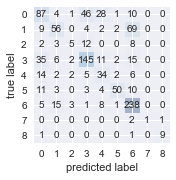

In [115]:
y_pred = model_pipeline.predict(X_test)
cm = confusion_matrix(y_target=Y_test, 
                      y_predicted=y_pred)
plot_confusion_matrix(conf_mat=cm)

# Predict eval set and export

In [116]:
#predictions
data_eval = test_full['Text']
y_pred=model_pipeline.predict_proba(data_eval)

In [117]:
y_pred[:10]

array([[  1.32917508e-03,   1.32014364e-01,   3.17536906e-04,
          2.97178689e-04,   4.59510786e-03,   7.46355159e-04,
          8.60107541e-01,   3.03972920e-04,   2.88841169e-04],
       [  3.87818813e-01,   4.57278378e-02,   1.21086300e-03,
          8.76787081e-02,   2.42957869e-03,   8.35664477e-03,
          4.59223151e-01,   1.73907587e-03,   5.81537513e-03],
       [  7.14224577e-03,   1.24497347e-01,   4.22252371e-04,
          1.42152771e-01,   4.17135842e-03,   3.79994715e-04,
          7.19982207e-01,   4.45412734e-04,   8.06395197e-04],
       [  3.61808948e-03,   6.91412836e-02,   6.33784744e-04,
          4.98995243e-04,   1.78537797e-03,   1.76302681e-03,
          9.21588361e-01,   4.88083082e-04,   4.82998381e-04],
       [  5.75249076e-01,   3.32793929e-02,   1.08529930e-03,
          2.31867790e-01,   2.56498298e-03,   3.94443190e-03,
          1.42115638e-01,   6.87296595e-03,   3.02038412e-03],
       [  2.46706959e-02,   1.20840548e-02,   1.76092435e-04,
   

In [118]:
#tweaking the submission file as required
# credit: https://www.kaggle.com/punyaswaroop12/gbm-starter-top-40
subm_file = pd.DataFrame(y_pred)
subm_file['id'] = eval_data_id
subm_file.columns = ['class1', 'class2', 'class3', 'class4', 'class5', 'class6', 'class7', 'class8', 'class9', 'id']
subm_file.to_csv(DATA_DIR+ "/submission_v1.csv",index=False)
subm_file.head(5)

,class1,class2,class3,class4,class5,class6,class7,class8,class9,id
0,0.001329,0.132014,0.000318,0.000297,0.004595,0.000746,0.860108,0.000304,0.000289,0
1,0.387819,0.045728,0.001211,0.087679,0.002430,0.008357,0.459223,0.001739,0.005815,1
2,0.007142,0.124497,0.000422,0.142153,0.004171,0.000380,0.719982,0.000445,0.000806,2
3,0.003618,0.069141,0.000634,0.000499,0.001785,0.001763,0.921588,0.000488,0.000483,3
4,0.575249,0.033279,0.001085,0.231868,0.002565,0.003944,0.142116,0.006873,0.003020,4


In [79]:
subm_file.shape

(5668, 10)